# Import and prepare everything

In [5]:
%load_ext autoreload
%autoreload

import os, sys

modules = os.path.abspath(os.path.join("..", "src"))
sys.path.append(modules)

import polars as pl
from transformers import AutoModel, AutoTokenizer
import nlp_utils, keywords_utils, load_utils, run_analysis
from config import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
web = pl.read_parquet(DATA_DIR + "processed/run_kw_matches.parquet").filter(pl.col("matches") != []).rename({"ID": "url"})
patents = pl.read_parquet(DATA_DIR + "processed/patent_kw_matches.parquet").filter(pl.col("matches") != []).rename({"ID": "Publication number"})

keywords_df = load_utils.load_keywords(KEYWORDS_FILE)
lookup = keywords_df.with_columns(pl.col("prompt_output").str.split(", ")).explode("prompt_output").rename({"prompt_output": "keyword"})


patent_company_lookup = load_utils.load_multiple_files(pattern = PATENTS_DIR + "Appl*.csv", filetype="csv")[:, 1:3].rename({"Applicant(s) BvD ID Number(s)": "ID"})
patent_company_lookup = patent_company_lookup.with_columns(pl.col("ID").str.split("; ")).explode("ID")

patents = patents.join(patent_company_lookup, on="Publication number", how = "inner")

lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url")
web = web.join(lf.collect(engine = "streaming"), on = "url")

patents = patents.explode("matches").rename({"matches": "keyword"}).join(lookup, on = "keyword")
web = web.explode("matches").rename({"matches": "keyword"}).join(lookup, on = "keyword")

name_lookup = (
    pl.read_csv(DATA_DIR + "raw/url_list_employees.csv").rename({"BVD": "ID"}).select("ID", "Name", "Canton", "n_employees")
).select("ID", "Name", "Canton") 

patents = patents.join(name_lookup, on = "ID")
web = web.join(name_lookup, on = "ID")

File ARGUS_chunk_p183.parquet is corrupted


In [54]:
patent_unique = patents.group_by("ID", "category").agg(
    pl.col("keyword").alias("unique_kw").n_unique(),
    Canton = pl.col("Canton").first()
)

web_unique = web.group_by("ID", "category").agg(
    pl.col("keyword").alias("unique_kw").n_unique(),
    Canton = pl.col("Canton").first()
)

# Compare

In [117]:
def compare_canton(df: pl.DataFrame, canton: str, thresh: int) -> pl.DataFrame:
    canton_unique = df.filter(pl.col("unique_kw") >= thresh).filter(
        pl.col("Canton") == canton
    )
    others_unique = df.filter(pl.col("unique_kw") >= thresh).filter(
        pl.col("Canton") != canton
    )

    canton_unique = canton_unique.group_by("category").agg(
        pl.len().alias(f"count_{canton}")
    )
    others_unique = others_unique.group_by("category").agg(
        pl.len().alias("count_others")
    )

    plot_data = canton_unique.join(others_unique, on="category")

    n_canton = plot_data.select(f"count_{canton}").sum().item()
    n_others = plot_data.select("count_others").sum().item()
    print(n_canton, n_others)

    plot_data = (
        plot_data.with_columns(
            (pl.col("count_" + canton) / n_canton).alias(f"percent_{canton}"),
        )
        .with_columns(
            (pl.col("count_others") / n_others).alias("percent_others"),
        )
        .with_columns(
            (pl.col("percent_" + canton) / pl.col("percent_others")).alias("ratio")
        )
        .with_columns(pl.col("ratio").log10().alias("logRTA"))
        .sort("logRTA", descending=True)
    )
    return plot_data

lucerne_web_1 = compare_canton(web_unique, "Lucerne", 1)
lucerne_patent_1 = compare_canton(patent_unique, "Lucerne", 1)

lucerne_web_3 = compare_canton(web_unique, "Lucerne", 3)
lucerne_patent_3 = compare_canton(patent_unique, "Lucerne", 3)
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax = plt.subplots(figsize=(12, 9))
# sns.barplot(x=plot_data["logRTA"], y=plot_data["category"])
# ax.axvline(0, color="black", linestyle="-", linewidth=2, alpha=0.8)

# ax.set_ylabel("Technology")
# ax.set_xlabel("Over- or Under-Representation (RTA)")
# min_rta = plot_data["logRTA"].min()
# max_rta = plot_data["logRTA"].max()
# x_ticks = [min_rta, min_rta / 2, 0, max_rta / 2, max_rta]
# x_labels = [f"{10**xt:.1f}x" for xt in x_ticks]
# # x_labels = ["-80%", "-40%", "0%", "+50%", "+100%"]
# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_labels)
# ax.set_title(
#     f"Technology Representation Analysis - {canton} vs. rest of Switzerland\nThreshold = {thresh}",
#     fontsize=14,
# )
# ax.set_xlabel("Over / Under-Representation (Log Scale)", fontsize=12)

# plt.tight_layout()
# plt.show()

1386 41573
364 15096
117 3721
28 1281


In [118]:
plot1 = lucerne_patent_1.join(lucerne_web_1, on = "category", suffix = "_web", how = "inner")
plot3 = lucerne_patent_3.join(lucerne_web_3, on = "category", suffix = "_web", how = "inner")

/home/msalvetti/notebooks_2/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  func(*args, **kwargs)
/home/msalvetti/notebooks_2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  fig.canvas.print_figure(bytes_io, **kw)


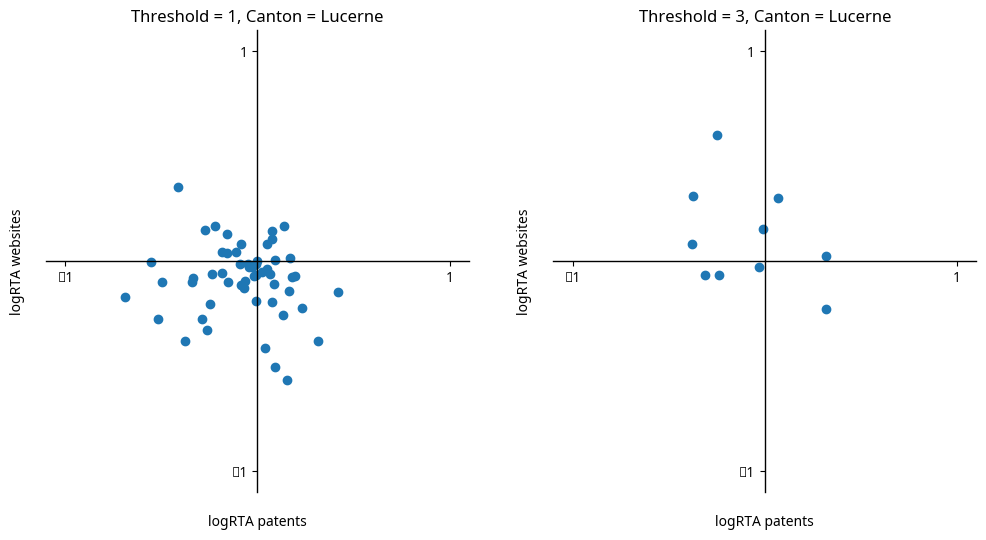

In [121]:
import matplotlib.pyplot as plt
plt.style.use("./style.mplstyle")
fig, ax = plt.subplots(figsize = (12,6), ncols=2, nrows = 1)

ax[0].scatter(data = plot1, x = "logRTA", y = "logRTA_web", label = plot1["category"])
ax[0].set_title("Threshold = 1, Canton = Lucerne")

ax[1].scatter(data = plot3, x = "logRTA", y = "logRTA_web", label = plot3["category"])
ax[1].set_title("Threshold = 3, Canton = Lucerne")

for a in ax:
    a.set_yticks([-1, 1])
    a.yaxis.set_label_coords(-0.05, 0)
    a.xaxis.set_label_coords(0, -0.05)
    a.set_xticks([-1, 1])

    a.set_ylim(-1.1, 1.1)
    a.set_xlim(-1.1, 1.1)
    a.spines["bottom"].set_position(("data", 0))
    a.spines["left"].set_position(("data", 0))

    a.set_ylabel("logRTA websites")
    a.set_xlabel("logRTA patents")
